## Modeling

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction import text 


import warnings
warnings.filterwarnings("ignore")

In [2]:
#reading data
subreddits = pd.read_csv('./data/merged_dfs.csv')

In [3]:
subreddits.head()

,created_utc,title,self_text,subreddit,sort
0,1.713893e+09,Free BOGO 9/22/24 Hockey Deal,I had seen yesterday that there was a bogo dea...,0,new
1,1.713893e+09,where did my points go?!?@?@?@,i had roughly 1500 points and when i went to u...,0,new
2,1.713890e+09,Pepper color…,Sitting here chomping down on my delicious bow...,0,new
3,1.713889e+09,Here’s why I don’t go to chipotle anymore,$13 with the drink from a small local business...,0,new
4,1.713888e+09,Fajita veggies,It’s absolutely insane you guys can’t have eno...,0,new


In [4]:
#checking to make sure everything merged properly
subreddits.isna().sum().sum()

0

In [5]:
subreddits.shape

(4693, 5)

Everything looks like it was imported correctly. So, now let's start building models :)

## TTS

In [6]:
#splitting data into target and features 
X = subreddits['self_text']
y = subreddits['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state = 66)

## Baseline

In [7]:
#calculating baseline to compare models 
y.value_counts(normalize = True)

subreddit
0    0.609418
1    0.390582
Name: proportion, dtype: float64

###### Note: `Chipotle` is encoded as 0 and `qdoba` is encoded as 1

The baseline indicates that if I were to guess which subreddit a post came from, I could guess `chipotle` and have a 60% chance at being correct

## Stop Words

In [8]:
#adding additional top words so model cant easily predict subreddits
stopwords_bias = ['qdoba', 'chipotle', 'Chipotle', 'Qdoba', 'CHIPOTLE', 'QDOBA']
default_stopwords = text.ENGLISH_STOP_WORDS

def stopwords_merger(stopwords_bias):
    return list(stopwords_bias) + list(default_stopwords)

## Logistic Regression

In [9]:
#lgr pipeline to do cvec and tfidf with hyperparamter grid search
def lgr_pipeliner(X_train, y_train, vectorizer):
    if vectorizer == 'cvec':
        params = {
            'cvec__max_features': [100, 200, 500, 1000],
            'cvec__stop_words': [stopwords_merger(stopwords_bias)],
            'cvec__ngram_range': [(1, 1), (1, 2)],
            'model__C': [0.1, 1, 10],
            'model__class_weight': [None, 'balanced']

        }
        pipeline = Pipeline([
            ('cvec', CountVectorizer()),
            ('model', LogisticRegression(max_iter=1000))
        ])
    elif vectorizer == 'tfidf':
        tfidf_params = {
            'tfidf__max_features': [100, 200, 500, 1000],
            'tfidf__stop_words': [stopwords_merger(stopwords_bias)],
            'tfidf__ngram_range': [(1, 1), (1, 2)],
            'model__C': [0.1, 1, 10],
            'model__class_weight': [None, 'balanced']

        }
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('model', LogisticRegression(max_iter=1000))
        ])

    grid_search = GridSearchCV(pipeline, param_grid=params if vectorizer == 'cvec' else tfidf_params)
    grid_search.fit(X_train, y_train)
    
    return grid_search

### CVEC

In [10]:
lgr_cvec_grid = lgr_pipeliner(X_train, y_train, 'cvec')

In [11]:
print("LGR CVEC GRID Train Score:", lgr_cvec_grid.score(X_train, y_train))
print("LGR CVEC GRID Test Score:", lgr_cvec_grid.score(X_test, y_test))
print("-----------")
print("LGR CVEC PERFORMANCE with TUNING:", lgr_cvec_grid.best_score_)

LGR CVEC GRID Train Score: 0.985881726158764
LGR CVEC GRID Test Score: 0.9371671991480298
-----------
LGR CVEC PERFORMANCE with TUNING: 0.9059692853972481


### TFIDF

In [12]:
lgr_tfidf_grid = lgr_pipeliner(X_train, y_train, 'tfidf')

In [13]:
print("LGR TFIDF GRID Train Score:", lgr_tfidf_grid.score(X_train, y_train))
print("LGR TFIDF GRID Test Score:", lgr_tfidf_grid.score(X_test, y_test))
print("-----------")
print("LGR TFIDF PERFORMANCE with TUNING:", lgr_tfidf_grid.best_score_)

LGR TFIDF GRID Train Score: 0.9552477357485349
LGR TFIDF GRID Test Score: 0.9158679446219382
-----------
LGR TFIDF PERFORMANCE with TUNING: 0.8803959165557036


#### The best NLP model for logistic regression seems to be the model using CountVectorizer. It has the best performance after being tuned with a 90.5% accuracy score. I will use this model for consideration when comparing the next model I will develop.

## Naive Bayes

In [14]:
#nb pipeline to do cvec and tfidf with hyperparamter grid search
def nb_pipeliner(X_train, y_train, vectorizer):
    if vectorizer == 'cvec':
        params = {
            'cvec__max_features': [100, 200, 500, 1000],
            'cvec__stop_words': [stopwords_merger(stopwords_bias)],
            'cvec__ngram_range': [(1, 1), (1, 2)],
            'model__alpha': [0.1, 0.5, 1.0],
        }
        pipeline = Pipeline([
            ('cvec', CountVectorizer()),
            ('model', MultinomialNB())
        ])
    elif vectorizer == 'tfidf':
        tfidf_params = {
            'tfidf__max_features': [100, 200, 500, 1000],
            'tfidf__stop_words': [stopwords_merger(stopwords_bias)],
            'tfidf__ngram_range': [(1, 1), (1, 2)],
            'model__alpha': [0.1, 0.5, 1.0]
        }
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('model', MultinomialNB())
        ])

    grid_search = GridSearchCV(pipeline, param_grid=params if vectorizer == 'cvec' else tfidf_params)
    grid_search.fit(X_train, y_train)
    
    return grid_search

### CVEC

In [15]:
nb_cvec_grid = nb_pipeliner(X_train, y_train, 'cvec')

In [16]:
print("NB CVEC GRID Train Score:", nb_cvec_grid.score(X_train, y_train))
print("NB CVEC GRID Test Score:", nb_cvec_grid.score(X_test, y_test))
print("-----------")
print("NB CVEC PERFORMANCE with TUNING:", nb_cvec_grid.best_score_)

NB CVEC GRID Train Score: 0.8332445391582313
NB CVEC GRID Test Score: 0.8072417465388712
-----------
NB CVEC PERFORMANCE with TUNING: 0.806610563692854


### TFIDF

In [17]:
nb_tfidf_grid = nb_pipeliner(X_train, y_train, 'tfidf')

In [18]:
print("NB TFIDF GRID Train Score:", nb_tfidf_grid.score(X_train, y_train))
print("NB TFIDF GRID Test Score:", nb_tfidf_grid.score(X_test, y_test))
print("-----------")
print("NB TFIDF PERFORMANCE with TUNING:", nb_tfidf_grid.best_score_)

NB TFIDF GRID Train Score: 0.8470964304741609
NB TFIDF GRID Test Score: 0.820021299254526
-----------
NB TFIDF PERFORMANCE with TUNING: 0.8167314691522414


#### The best NLP model for Naive Bayes seems to be the model using TFIDFVectorizer. It has the best performance after being tuned with a 81.6% accuracy score. I will use this model for consideration when comparing the next model I will develop.

## KNN with CVEC

In [19]:
#knn pipeline to do cvec and tfidf with hyperparamter grid search
def knn_pipeliner(X_train, y_train, vectorizer):
    vectorizer == 'cvec'
    params = {
        'cvec__max_features': [100, 200, 500, 1000],
        'cvec__stop_words': [stopwords_merger(stopwords_bias)],
        'cvec__ngram_range': [(1, 1), (1, 2)],
        'model__n_neighbors': [3, 5, 7, 9], 
        'model__weights': ['uniform', 'distance']
    }
    pipeline = Pipeline([
        ('cvec', CountVectorizer()),
        ('model', KNeighborsClassifier())
        ])
    
    grid_search = GridSearchCV(pipeline, param_grid=params)
    grid_search.fit(X_train, y_train)
    
    return grid_search

In [20]:
knn_cvec_grid = knn_pipeliner(X_train, y_train, 'cvec')

In [21]:
print("KNN CVEC GRID Train Score:", knn_cvec_grid.score(X_train, y_train))
print("KNN CVEC GRID Test Score:", knn_cvec_grid.score(X_test, y_test))
print("-----------")
print("KNN CVEC PERFORMANCE with TUNING:", knn_cvec_grid.best_score_)

KNN CVEC GRID Train Score: 0.9933404368673415
KNN CVEC GRID Test Score: 0.9648562300319489
-----------
KNN CVEC PERFORMANCE with TUNING: 0.9384632046160675


## Random Forest

In [22]:
#rf pipeline to do cvec and tfidf with hyperparamter grid search
def rf_pipeliner(X_train, y_train, vectorizer):
    if vectorizer == 'cvec':
        params = {
            'cvec__max_features': [100, 200, 500, 1000],
            'cvec__stop_words': [stopwords_merger(stopwords_bias)],
            'cvec__ngram_range': [(1, 1), (1, 2)],
            'model__max_depth': [None, 10, 20]
        }
        pipeline = Pipeline([
            ('cvec', CountVectorizer()),
            ('model', RandomForestClassifier())
        ])
    elif vectorizer == 'tfidf':
        params = {
            'tfidf__max_features': [100, 200, 500, 1000],
            'tfidf__stop_words': [stopwords_merger(stopwords_bias)],
            'tfidf__ngram_range': [(1, 1), (1, 2)],
            'model__max_depth': [None, 10, 20]
        }
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('model', RandomForestClassifier())
        ])
    grid_search = GridSearchCV(pipeline, param_grid=params if vectorizer == 'cvec' else params)
    grid_search.fit(X_train, y_train)
    
    return grid_search

### CVEC

In [23]:
rf_cvec_grid = rf_pipeliner(X_train, y_train, 'cvec')

In [24]:
print("RF CVEC GRID Train Score:", rf_cvec_grid.score(X_train, y_train))
print("RF CVEC GRID Test Score:", rf_cvec_grid.score(X_test, y_test))
print("-----------")
print("RF CVEC PERFORMANCE with TUNING:", rf_cvec_grid.best_score_)

RF CVEC GRID Train Score: 0.9933404368673415
RF CVEC GRID Test Score: 0.972310969116081
-----------
RF CVEC PERFORMANCE with TUNING: 0.9456561029738128


### TFIDF

In [25]:
rf_tfidf_grid = rf_pipeliner(X_train, y_train, 'tfidf')

In [26]:
print("RF TFIDF GRID Train Score:", rf_tfidf_grid.score(X_train, y_train))
print("RF TFIDF GRID Test Score:", rf_tfidf_grid.score(X_test, y_test))
print("-----------")
print("RF TFIDF PERFORMANCE with TUNING:", rf_tfidf_grid.best_score_)

RF TFIDF GRID Train Score: 0.9933404368673415
RF TFIDF GRID Test Score: 0.9744408945686901
-----------
RF TFIDF PERFORMANCE with TUNING: 0.9477897913892587


#### The best NLP model for Random Forest seems to be the model using TFIDFVectorizer. It has the best performance after being tuned with a 94.77% accuracy score. I will use this model for consideration when choosing the best performing the model overall.

## Best Model Overall

In [39]:
#retaining only the models that had the best tuning performance
models = pd.DataFrame({'estimators': ['logreg cvec', 
                            'naive bayes tfidf',
                            'knn cvec',
                            'random forest tfidf',
                            'baseline'],
                       
            'train score acc': [lgr_cvec_grid.score(X_train, y_train),
                              nb_tfidf_grid.score(X_train, y_train),
                              knn_cvec_grid.score(X_train, y_train),
                              rf_tfidf_grid.score(X_train, y_train),
                             ' '],
                       
              'test score acc': [lgr_cvec_grid.score(X_test, y_test),
                              nb_tfidf_grid.score(X_test, y_test),
                              knn_cvec_grid.score(X_test, y_test),
                              rf_tfidf_grid.score(X_test, y_test),
                             y.value_counts(normalize = True)[0]],
                       
         
                
             })
#displaying models df with highest estimator based on test score accuracy
models.sort_values(by = 'test score acc', ascending = False)

,estimators,train score acc,test score acc
3,random forest tfidf,0.99334,0.974441
2,knn cvec,0.99334,0.964856
0,logreg cvec,0.985882,0.937167
1,naive bayes tfidf,0.847096,0.820021
4,baseline,,0.609418


The highest performing model was the `RandomForestClassifier` using `TfidfVectorizer`. It had an accuracy score of 97.4% on the test set. This indicates that the model performed better than the baseline which was only 60% accurate at predicting posts at random.

### Evaluations and Visualizations

In [28]:
#params that made random forest the best model
# i chose to use best_estimator instead of best_params to save space
rf_tfidf_grid.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000,
                                 stop_words=['qdoba', 'chipotle', 'Chipotle',
                                             'Qdoba', 'CHIPOTLE', 'QDOBA',
                                             'alone', 'such', 'name', 'our',
                                             'whose', 'thick', 'himself',
                                             'another', 'in', 'you', 'except',
                                             'themselves', 'by', 'un',
                                             'amongst', 'who', 'seemed',
                                             'about', 'somewhere', 'fifty',
                                             'latter', 'off', 'she', 'have', ...])),
                ('model', RandomForestClassifier())])

In [41]:
#test preds for classification report
y_preds = rf_tfidf_grid.predict(X_test)

In [42]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       584
           1       0.95      0.98      0.97       355

    accuracy                           0.97       939
   macro avg       0.97      0.98      0.97       939
weighted avg       0.97      0.97      0.97       939



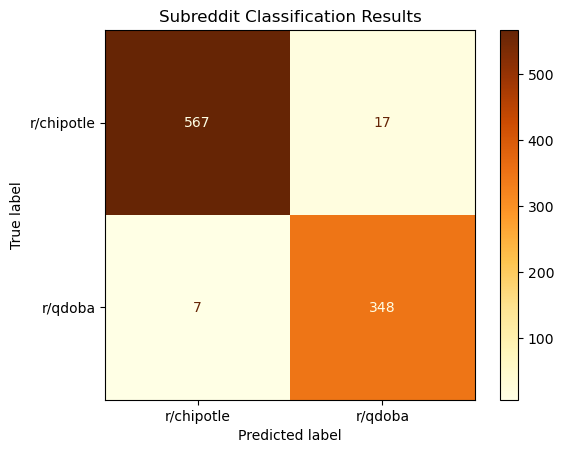

In [43]:
#creating confusion matrix with subreddits as labels for visualization
class_names = ['r/chipotle', 'r/qdoba']
ConfusionMatrixDisplay.from_estimator(rf_tfidf_grid, X_test, y_test, cmap = 'YlOrBr', display_labels=class_names)
plt.title("Subreddit Classification Results");

The `RF TFIDF` model only made 23 incorrect predictions out of 939 on the test set. It has very little false negatives and false positives. For example, it incorrectly predicted chipotle for qdoba 7 times out of 355 qdoba posts, and incorrectly predicted qdoba 17 times out of 584 chipotle posts.

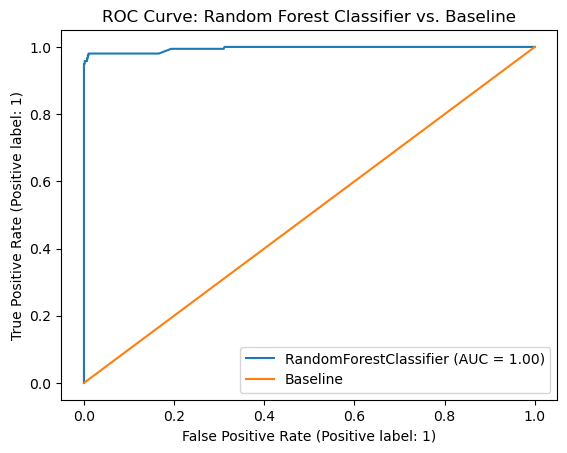

In [44]:
#making an roc cure to show the tradeoff between TPR and FPR
RocCurveDisplay.from_estimator(rf_tfidf_grid,X_test,y_test, name = 'RandomForestClassifier')
plt.plot([0,1], [0,1], label = 'Baseline')
plt.legend()
plt.title("ROC Curve: Random Forest Classifier vs. Baseline");

The ROC Curve further demonstrates how model behave as the threshold is adjusted. Despite increasing the FPR, the model is not showing a corresponding rise in the TPR. The AUC value further quantifies the model's performance. There is a perfect score of 1 which indicates optimal performance.

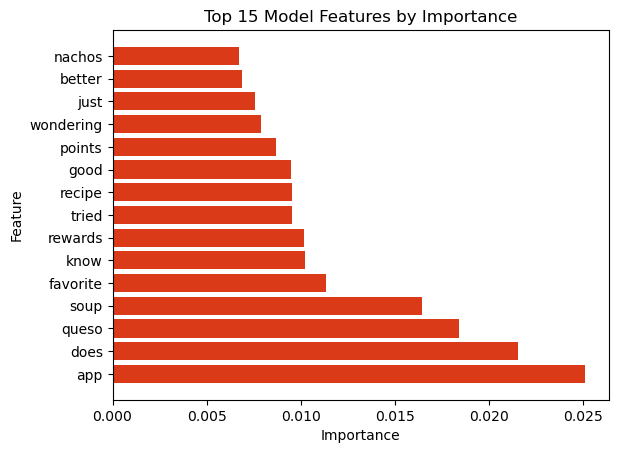

In [45]:
#creating graph to show what features the model used  to best predict the subreddits

best_model = rf_tfidf_grid.best_estimator_
rf_model = best_model.named_steps['model']

#getting the feature importances
importances = rf_model.feature_importances_
features = best_model.named_steps['tfidf'].get_feature_names_out()
importance_df = pd.DataFrame({'importance': importances, 'features': features}).nlargest(15, 'importance')

plt.barh(importance_df['features'], importance_df['importance'], color ='#DA3A18')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Model Features by Importance');

Words such as `app`, along with `queso` and `soup` played a crucial role in teaching the model to distinguish between the different subreddits. For example, `app` received an importance rating of greater than 0.025 meaning the Chipotle's and Qdoba's app primarily helped the model make its predictions.